In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-02 00:37:23.988249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 00:37:23.994365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 00:37:23.994869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-02 00:37:24.281083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 00:37:24.281865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 00:37:24.282347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 00:37:24.282689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[2.0012093e+00, 0.0000000e+00, 0.0000000e+00],
         [2.3691981e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 6.0123140e-01],
         ...,
         [2.4702482e+00, 0.0000000e+00, 1.4184349e+00],
         [0.0000000e+00, 0.0000000e+00, 1.2240335e+00],
         [2.8655515e+00, 1.1402203e+00, 9.4790536e-01]],

        [[0.0000000e+00, 0.0000000e+00, 9.6045810e-01],
         [0.0000000e+00, 2.0088662e-01, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 2.2667739e+00],
         ...,
         [0.0000000e+00, 8.4304255e-01, 0.0000000e+00],
         [3.5755475e+00, 1.6306496e+00, 1.8062224e+00],
         [4.3878862e-01, 0.0000000e+00, 4.8253053e-01]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 4.7738859e-01],
         [0.0000000e+00, 0.0000000e+00, 4.2027159e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 1.0472440e+00],


In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[2.0012093e+00, 0.0000000e+00, 0.0000000e+00],
          [2.3691981e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 6.0123140e-01],
          ...,
          [2.4702482e+00, 0.0000000e+00, 1.4184349e+00],
          [0.0000000e+00, 0.0000000e+00, 1.2240335e+00],
          [2.8655515e+00, 1.1402203e+00, 9.4790536e-01]],
 
         [[0.0000000e+00, 0.0000000e+00, 9.6045810e-01],
          [0.0000000e+00, 2.0088662e-01, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 2.2667739e+00],
          ...,
          [0.0000000e+00, 8.4304255e-01, 0.0000000e+00],
          [3.5755475e+00, 1.6306496e+00, 1.8062224e+00],
          [4.3878862e-01, 0.0000000e+00, 4.8253053e-01]],
 
         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 4.7738859e-01],
          [0.0000000e+00, 0.0000000e+00, 4.2027159e+00],
          ...,
          [0.0000000e+00, 

<IPython.core.display.Javascript object>


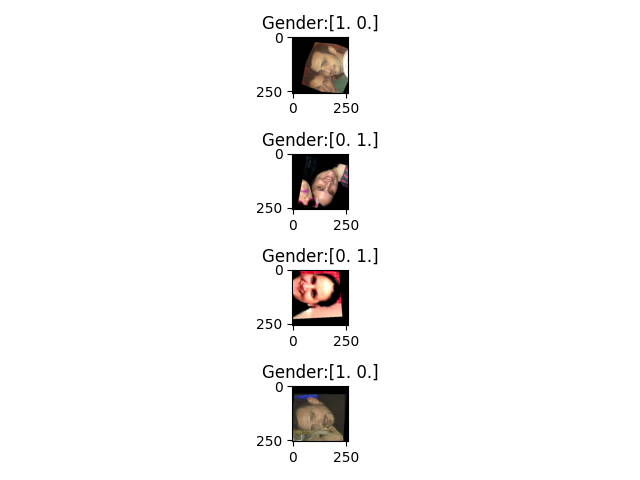

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_6')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 128

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 128)          1264064     ['tf.math.subtract[0][0]']    

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
# Transfomer Tensorflow Tutorial
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, factor, warmupSteps=5000):
        self.factor = tf.cast(factor, tf.float32)
        self.warmupSteps = warmupSteps
        
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        a1 = tf.math.rsqrt(step)
        a2 = step * (self.warmupSteps ** -1.5)
        return self.factor * tf.math.minimum(a1, a2)

In [38]:
logBasePath = "log/AE_6"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    lrSchedule = CustomSchedule(0.001)
    
    opt = tf.keras.optimizers.Adam(learning_rate=lrSchedule)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))

    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-02 00:37:34.829099: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-02 00:37:34.829123: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-02 00:37:34.829142: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-02 00:37:34.935400: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-02 00:37:34.936708: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-02 00:37:35.571660: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  14/3528 [..............................] - ETA: 13s - loss: 7251.1235 - gender_out_loss: 0.6879 - tf.math.multiply_1_loss: 5531.3086 - gender_out_accuracy: 0.5714    

2022-11-02 00:37:36.321690: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 16s 4ms/step - loss: 7731.6177 - gender_out_loss: 0.6964 - tf.math.multiply_1_loss: 5990.6489 - gender_out_accuracy: 0.4768
Epoch 1/300
   1/1000 [..............................] - ETA: 13:51 - loss: 7821.3262 - gender_out_loss: 0.6824 - tf.math.multiply_1_loss: 6115.3672 - gender_out_accuracy: 0.5000

2022-11-02 00:37:51.441502: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-02 00:37:51.441566: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   8/1000 [..............................] - ETA: 1:15 - loss: 8774.9922 - gender_out_loss: 0.6678 - tf.math.multiply_1_loss: 7105.3804 - gender_out_accuracy: 0.7188

2022-11-02 00:37:51.989044: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-02 00:37:51.990135: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-02 00:37:52.027526: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3215 callback api events and 3174 activity events. 
2022-11-02 00:37:52.056433: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-02 00:37:52.096681: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_6/log_0/plugins/profile/2022_11_02_00_37_52

2022-11-02 00:37:52.151752: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_6/log_0/plugins/profile/2022_11_02_00_37_52/rachanon-pc1.trace.json.gz


  30/1000 [..............................] - ETA: 31s - loss: 9035.4531 - gender_out_loss: 0.6792 - tf.math.multiply_1_loss: 7337.4429 - gender_out_accuracy: 0.6083

2022-11-02 00:37:52.194670: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_6/log_0/plugins/profile/2022_11_02_00_37_52

2022-11-02 00:37:52.200449: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/AE_6/log_0/plugins/profile/2022_11_02_00_37_52/rachanon-pc1.memory_profile.json.gz
2022-11-02 00:37:52.201449: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/AE_6/log_0/plugins/profile/2022_11_02_00_37_52
Dumped tool data for xplane.pb to log/AE_6/log_0/plugins/profile/2022_11_02_00_37_52/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/AE_6/log_0/plugins/profile/2022_11_02_00_37_52/rachanon-pc1.overview_page.pb
Dumped tool data for input_pipeline.pb to log/AE_6/log_0/plugins/profile/2022_11_02_00_37_52/rachanon-pc1.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to log/AE_6/log_0/plugins/profile/2022_11_02_00_37_52/ra

1000/1000 [==============================] - 24s 23ms/step - loss: 9336.3594 - gender_out_loss: 0.6933 - tf.math.multiply_1_loss: 7603.0234 - gender_out_accuracy: 0.5117 - val_loss: 7481.7744 - val_gender_out_loss: 0.6914 - val_tf.math.multiply_1_loss: 5753.3770 - val_gender_out_accuracy: 0.5535
Epoch 2/300
1000/1000 [==============================] - 22s 22ms/step - loss: 6437.2192 - gender_out_loss: 0.6893 - tf.math.multiply_1_loss: 4714.0630 - gender_out_accuracy: 0.5530 - val_loss: 5644.4834 - val_gender_out_loss: 0.6870 - val_tf.math.multiply_1_loss: 3927.0808 - val_gender_out_accuracy: 0.5427
Epoch 3/300
1000/1000 [==============================] - 22s 22ms/step - loss: 5153.0483 - gender_out_loss: 0.6667 - tf.math.multiply_1_loss: 3486.3325 - gender_out_accuracy: 0.5997 - val_loss: 5046.8560 - val_gender_out_loss: 0.6908 - val_tf.math.multiply_1_loss: 3319.8535 - val_gender_out_accuracy: 0.5255
Epoch 4/300
1000/1000 [==============================] - 22s 22ms/step - loss: 4550.7

1000/1000 [==============================] - 22s 22ms/step - loss: 2755.2556 - gender_out_loss: 0.6549 - tf.math.multiply_1_loss: 1118.0608 - gender_out_accuracy: 0.6122 - val_loss: 3367.0439 - val_gender_out_loss: 0.7904 - val_tf.math.multiply_1_loss: 1391.1222 - val_gender_out_accuracy: 0.5299
Epoch 28/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2882.2019 - gender_out_loss: 0.6775 - tf.math.multiply_1_loss: 1188.4076 - gender_out_accuracy: 0.5738 - val_loss: 3071.9951 - val_gender_out_loss: 0.6851 - val_tf.math.multiply_1_loss: 1359.1256 - val_gender_out_accuracy: 0.5533
Epoch 29/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2839.7327 - gender_out_loss: 0.6803 - tf.math.multiply_1_loss: 1138.9126 - gender_out_accuracy: 0.5615 - val_loss: 3031.1802 - val_gender_out_loss: 0.6733 - val_tf.math.multiply_1_loss: 1347.8080 - val_gender_out_accuracy: 0.5829
Epoch 30/300
1000/1000 [==============================] - 22s 22ms/step - loss: 282

1000/1000 [==============================] - 22s 22ms/step - loss: 2729.8726 - gender_out_loss: 0.6765 - tf.math.multiply_1_loss: 1038.5648 - gender_out_accuracy: 0.5602 - val_loss: 2888.2151 - val_gender_out_loss: 0.6708 - val_tf.math.multiply_1_loss: 1211.2256 - val_gender_out_accuracy: 0.5879
Epoch 54/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2698.3430 - gender_out_loss: 0.6815 - tf.math.multiply_1_loss: 994.5417 - gender_out_accuracy: 0.5512 - val_loss: 2959.3628 - val_gender_out_loss: 0.7000 - val_tf.math.multiply_1_loss: 1209.2477 - val_gender_out_accuracy: 0.4986
Epoch 55/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2708.3367 - gender_out_loss: 0.6817 - tf.math.multiply_1_loss: 1004.0578 - gender_out_accuracy: 0.5673 - val_loss: 2865.7356 - val_gender_out_loss: 0.6698 - val_tf.math.multiply_1_loss: 1191.3214 - val_gender_out_accuracy: 0.5839
Epoch 56/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2673

1000/1000 [==============================] - 22s 22ms/step - loss: 2651.7925 - gender_out_loss: 0.6902 - tf.math.multiply_1_loss: 926.2212 - gender_out_accuracy: 0.5345 - val_loss: 2820.9307 - val_gender_out_loss: 0.6765 - val_tf.math.multiply_1_loss: 1129.7397 - val_gender_out_accuracy: 0.5824
Epoch 80/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2576.0935 - gender_out_loss: 0.6622 - tf.math.multiply_1_loss: 920.5052 - gender_out_accuracy: 0.6047 - val_loss: 2848.5461 - val_gender_out_loss: 0.6745 - val_tf.math.multiply_1_loss: 1162.2318 - val_gender_out_accuracy: 0.5643
Epoch 81/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2664.9395 - gender_out_loss: 0.6788 - tf.math.multiply_1_loss: 967.9621 - gender_out_accuracy: 0.5707 - val_loss: 2834.0515 - val_gender_out_loss: 0.6816 - val_tf.math.multiply_1_loss: 1130.1370 - val_gender_out_accuracy: 0.5558
Epoch 82/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2676.0

1000/1000 [==============================] - 22s 22ms/step - loss: 2575.8188 - gender_out_loss: 0.6607 - tf.math.multiply_1_loss: 924.1584 - gender_out_accuracy: 0.5968 - val_loss: 2753.9812 - val_gender_out_loss: 0.6670 - val_tf.math.multiply_1_loss: 1086.5106 - val_gender_out_accuracy: 0.5839
Epoch 106/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2613.8687 - gender_out_loss: 0.6808 - tf.math.multiply_1_loss: 911.9581 - gender_out_accuracy: 0.5630 - val_loss: 2812.9778 - val_gender_out_loss: 0.6831 - val_tf.math.multiply_1_loss: 1105.1597 - val_gender_out_accuracy: 0.5601
Epoch 107/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2610.6208 - gender_out_loss: 0.6824 - tf.math.multiply_1_loss: 904.6936 - gender_out_accuracy: 0.5610 - val_loss: 2760.3765 - val_gender_out_loss: 0.6667 - val_tf.math.multiply_1_loss: 1093.5220 - val_gender_out_accuracy: 0.5841
Epoch 108/300
1000/1000 [==============================] - 22s 22ms/step - loss: 260

1000/1000 [==============================] - 22s 22ms/step - loss: 2595.2354 - gender_out_loss: 0.6758 - tf.math.multiply_1_loss: 905.6742 - gender_out_accuracy: 0.5720 - val_loss: 2732.5457 - val_gender_out_loss: 0.6695 - val_tf.math.multiply_1_loss: 1058.6814 - val_gender_out_accuracy: 0.5795
Epoch 132/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2582.1594 - gender_out_loss: 0.6857 - tf.math.multiply_1_loss: 868.0104 - gender_out_accuracy: 0.5445 - val_loss: 2734.9624 - val_gender_out_loss: 0.6684 - val_tf.math.multiply_1_loss: 1063.8457 - val_gender_out_accuracy: 0.5867
Epoch 133/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2504.3079 - gender_out_loss: 0.6549 - tf.math.multiply_1_loss: 867.1171 - gender_out_accuracy: 0.6158 - val_loss: 2754.3130 - val_gender_out_loss: 0.6685 - val_tf.math.multiply_1_loss: 1082.9586 - val_gender_out_accuracy: 0.5905
Epoch 134/300
1000/1000 [==============================] - 22s 22ms/step - loss: 260

1000/1000 [==============================] - 22s 22ms/step - loss: 2570.1799 - gender_out_loss: 0.6761 - tf.math.multiply_1_loss: 880.0201 - gender_out_accuracy: 0.5785 - val_loss: 2716.9500 - val_gender_out_loss: 0.6671 - val_tf.math.multiply_1_loss: 1049.2863 - val_gender_out_accuracy: 0.5915
Epoch 158/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2481.1711 - gender_out_loss: 0.6513 - tf.math.multiply_1_loss: 852.9916 - gender_out_accuracy: 0.6195 - val_loss: 2708.1765 - val_gender_out_loss: 0.6654 - val_tf.math.multiply_1_loss: 1044.5642 - val_gender_out_accuracy: 0.5866
Epoch 159/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2586.3821 - gender_out_loss: 0.6798 - tf.math.multiply_1_loss: 886.9413 - gender_out_accuracy: 0.5610 - val_loss: 2711.4661 - val_gender_out_loss: 0.6679 - val_tf.math.multiply_1_loss: 1041.7699 - val_gender_out_accuracy: 0.5866
Epoch 160/300
1000/1000 [==============================] - 22s 22ms/step - loss: 256

1000/1000 [==============================] - 22s 22ms/step - loss: 2532.3284 - gender_out_loss: 0.6590 - tf.math.multiply_1_loss: 884.8107 - gender_out_accuracy: 0.5955 - val_loss: 2712.4153 - val_gender_out_loss: 0.6727 - val_tf.math.multiply_1_loss: 1030.6112 - val_gender_out_accuracy: 0.5896
Epoch 184/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2559.8367 - gender_out_loss: 0.6764 - tf.math.multiply_1_loss: 868.7488 - gender_out_accuracy: 0.5667 - val_loss: 2701.5298 - val_gender_out_loss: 0.6708 - val_tf.math.multiply_1_loss: 1024.4840 - val_gender_out_accuracy: 0.5959
Epoch 185/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2546.4238 - gender_out_loss: 0.6788 - tf.math.multiply_1_loss: 849.3336 - gender_out_accuracy: 0.5677 - val_loss: 2702.9341 - val_gender_out_loss: 0.6683 - val_tf.math.multiply_1_loss: 1032.1285 - val_gender_out_accuracy: 0.5886
Epoch 186/300
1000/1000 [==============================] - 22s 22ms/step - loss: 248

1000/1000 [==============================] - 22s 22ms/step - loss: 2565.9136 - gender_out_loss: 0.6844 - tf.math.multiply_1_loss: 854.8695 - gender_out_accuracy: 0.5428 - val_loss: 2683.6426 - val_gender_out_loss: 0.6664 - val_tf.math.multiply_1_loss: 1017.7665 - val_gender_out_accuracy: 0.5982
Epoch 210/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2554.0413 - gender_out_loss: 0.6765 - tf.math.multiply_1_loss: 862.6693 - gender_out_accuracy: 0.5800 - val_loss: 2688.4424 - val_gender_out_loss: 0.6691 - val_tf.math.multiply_1_loss: 1015.7603 - val_gender_out_accuracy: 0.5732
Epoch 211/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2484.4109 - gender_out_loss: 0.6526 - tf.math.multiply_1_loss: 852.9285 - gender_out_accuracy: 0.6143 - val_loss: 2707.9558 - val_gender_out_loss: 0.6731 - val_tf.math.multiply_1_loss: 1025.1514 - val_gender_out_accuracy: 0.5906
Epoch 212/300
1000/1000 [==============================] - 22s 22ms/step - loss: 255

1000/1000 [==============================] - 22s 22ms/step - loss: 2515.9236 - gender_out_loss: 0.6757 - tf.math.multiply_1_loss: 826.6092 - gender_out_accuracy: 0.5895 - val_loss: 2664.7625 - val_gender_out_loss: 0.6632 - val_tf.math.multiply_1_loss: 1006.7788 - val_gender_out_accuracy: 0.5817
Epoch 236/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2490.8721 - gender_out_loss: 0.6584 - tf.math.multiply_1_loss: 844.9600 - gender_out_accuracy: 0.5970 - val_loss: 2666.6216 - val_gender_out_loss: 0.6642 - val_tf.math.multiply_1_loss: 1006.1631 - val_gender_out_accuracy: 0.5929
Epoch 237/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2526.5281 - gender_out_loss: 0.6726 - tf.math.multiply_1_loss: 845.0656 - gender_out_accuracy: 0.5770 - val_loss: 2684.0330 - val_gender_out_loss: 0.6706 - val_tf.math.multiply_1_loss: 1007.4091 - val_gender_out_accuracy: 0.6022
Epoch 238/300
1000/1000 [==============================] - 22s 22ms/step - loss: 251

1000/1000 [==============================] - 22s 22ms/step - loss: 2553.4392 - gender_out_loss: 0.6750 - tf.math.multiply_1_loss: 865.8740 - gender_out_accuracy: 0.5745 - val_loss: 2668.4712 - val_gender_out_loss: 0.6676 - val_tf.math.multiply_1_loss: 999.5764 - val_gender_out_accuracy: 0.5744
Epoch 262/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2534.4895 - gender_out_loss: 0.6814 - tf.math.multiply_1_loss: 831.1023 - gender_out_accuracy: 0.5612 - val_loss: 2660.1379 - val_gender_out_loss: 0.6635 - val_tf.math.multiply_1_loss: 1001.3162 - val_gender_out_accuracy: 0.6016
Epoch 263/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2531.1599 - gender_out_loss: 0.6758 - tf.math.multiply_1_loss: 841.5875 - gender_out_accuracy: 0.5880 - val_loss: 2667.8340 - val_gender_out_loss: 0.6676 - val_tf.math.multiply_1_loss: 998.8176 - val_gender_out_accuracy: 0.5711
Epoch 264/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2484.

1000/1000 [==============================] - 22s 22ms/step - loss: 2523.2058 - gender_out_loss: 0.6800 - tf.math.multiply_1_loss: 823.1097 - gender_out_accuracy: 0.5680 - val_loss: 2668.2361 - val_gender_out_loss: 0.6689 - val_tf.math.multiply_1_loss: 995.9750 - val_gender_out_accuracy: 0.5919
Epoch 288/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2471.2041 - gender_out_loss: 0.6648 - tf.math.multiply_1_loss: 809.0968 - gender_out_accuracy: 0.6050 - val_loss: 2940.6958 - val_gender_out_loss: 0.7751 - val_tf.math.multiply_1_loss: 1002.8639 - val_gender_out_accuracy: 0.5434
Epoch 289/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2510.4150 - gender_out_loss: 0.6683 - tf.math.multiply_1_loss: 839.7135 - gender_out_accuracy: 0.5817 - val_loss: 2644.1990 - val_gender_out_loss: 0.6616 - val_tf.math.multiply_1_loss: 990.2051 - val_gender_out_accuracy: 0.5907
Epoch 290/300
1000/1000 [==============================] - 22s 22ms/step - loss: 2511.

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[17.054024  ,  6.5906706 , 12.481691  ],
          [15.509012  ,  7.446932  , 10.051761  ],
          [ 3.2068987 ,  2.8847141 ,  5.281724  ],
          ...,
          [ 4.948049  ,  3.9587035 ,  4.043006  ],
          [ 5.4567275 ,  4.1619167 ,  6.8914776 ],
          [ 9.740945  ,  7.0690646 ,  7.8064833 ]],
 
         [[12.680717  , 12.159431  , 10.371529  ],
          [ 1.7611295 ,  2.4423342 ,  2.5870988 ],
          [ 0.65177906,  1.0640417 ,  0.91274905],
          ...,
          [ 1.1683462 ,  1.1432066 ,  1.4218837 ],
          [ 1.8093641 ,  1.9485582 ,  1.7323499 ],
          [ 3.6280832 ,  3.5605001 ,  3.8077302 ]],
 
         [[ 5.2162843 ,  5.495805  ,  4.4726186 ],
          [ 1.9225297 ,  0.9785083 ,  1.0345173 ],
          [ 0.2719058 ,  0.2702491 ,  0.46251118],
          ...,
          [ 0.555515  ,  0.46441108,  0.5872357 ],
          [ 0.7920219 ,  0.9482695 ,  1.1304014 ],
          [ 1.

<IPython.core.display.Javascript object>


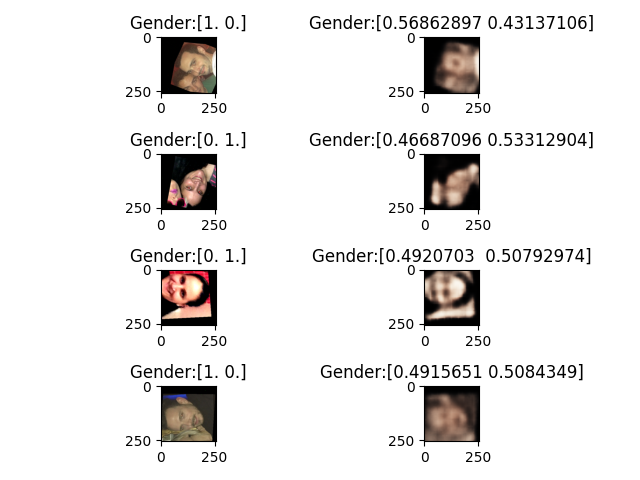

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[ 42.697094  ,  25.408302  ,  34.02757   ],
          [ 41.002155  ,  26.967176  ,  31.159992  ],
          [ 18.60998   ,  16.087858  ,  22.633478  ],
          ...,
          [  3.3347695 ,   2.6430166 ,   2.7650812 ],
          [  3.7512574 ,   2.8354077 ,   5.0833673 ],
          [  7.303854  ,   5.167647  ,   5.8261514 ]],
 
         [[ 37.553356  ,  36.229164  ,  32.41493   ],
          [ 12.4904995 ,  14.648313  ,  15.437203  ],
          [  7.3813243 ,   9.683993  ,   8.485499  ],
          ...,
          [  0.64968914,   0.652425  ,   0.84671617],
          [  1.0896372 ,   1.2035778 ,   1.0796057 ],
          [  2.3985224 ,   2.384775  ,   2.6087425 ]],
 
         [[ 23.00632   ,  24.005249  ,  19.020456  ],
          [ 13.408857  ,   8.901144  ,   9.004749  ],
          [  5.0960207 ,   4.5157537 ,   6.2955403 ],
          ...,
          [  0.2832748 ,   0.23793563,   0.31596825],
          [  0.42

<IPython.core.display.Javascript object>


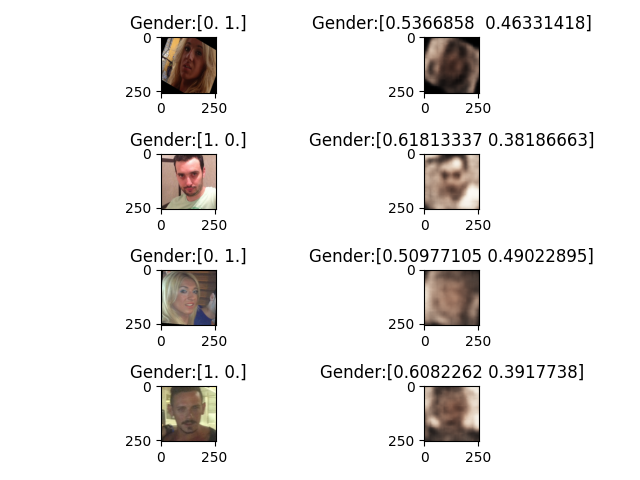

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()